# Q-GAN: (Q-Net) + GAN (G-Net and D-Net)

More specifically, we'll use Q-GAN to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
import gym
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards, states, actions, dones = [], [], [], []
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    states.append(state)
    rewards.append(reward)
    actions.append(action)
    dones.append(done)
    print('state, action, reward, done, info')
    print(state, action, reward, done, info)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        dones.append(done)

state, action, reward, done, info
[-0.00090499 -0.1928352  -0.03145304  0.32617311] 0 1.0 False {}
state, action, reward, done, info
[-0.0047617   0.00272012 -0.02492958  0.02373954] 1 1.0 False {}
state, action, reward, done, info
[-0.00470729  0.19819055 -0.02445479 -0.27670353] 1 1.0 False {}
state, action, reward, done, info
[-0.00074348  0.00342587 -0.02998886  0.00816714] 0 1.0 False {}
state, action, reward, done, info
[-0.00067497  0.19896478 -0.02982552 -0.29382475] 1 1.0 False {}
state, action, reward, done, info
[ 0.00330433  0.39449898 -0.03570201 -0.59576301] 1 1.0 False {}
state, action, reward, done, info
[ 0.01119431  0.59010192 -0.04761727 -0.89947461] 1 1.0 False {}
state, action, reward, done, info
[ 0.02299635  0.78583572 -0.06560676 -1.20673671] 1 1.0 False {}
state, action, reward, done, info
[ 0.03871306  0.98174112 -0.0897415  -1.51923717] 1 1.0 False {}
state, action, reward, done, info
[ 0.05834789  1.17782615 -0.12012624 -1.83852972] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
(10,) (10, 4) (10,) (10,)
float64 float64 int64 bool
1 0
2
1.0 1.0
1.177826153139452 -1.838529723915487


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [5]:
def model_input(state_size):
    # Given data
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    
    # Actions as output
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, next_states, actions, targetQs

In [8]:
# Q: qfunction/encoder
def qfunction(states, action_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('qfunction', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits_actions)

        # return actions logits
        return logits

In [9]:
# G: generator/ decoder: actions can be given actions, generated actions
def generator(actions, state_size, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=actions, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=state_size)        
        #predictions = tf.sigmoid(logits)

        # return next_states_logits
        return logits

In [10]:
# D: descriminator/reward function
def discriminator(states, hidden_size, reuse=False, alpha=0.1):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        nl1 = tf.maximum(alpha * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        nl2 = tf.maximum(alpha * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)   
        #predictions = tf.sigmoid(logits)

        # return reward logits
        return logits

In [11]:
def model_loss(states, action_size, hidden_size, actions, targetQs, state_size, next_states, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param states: real current input states or observations given
    :param actions: real actions given
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Q-learning: Bellman equations: loss (targetQ - Q)^2
    actions_logits = qfunction(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_real = tf.one_hot(actions, action_size)
    Qs = tf.reduce_sum(tf.multiply(actions_logits, actions_real), axis=1)
    q_loss = tf.reduce_mean(tf.square(targetQs - Qs))

    # GAN: Generate next states
    actions_fake = tf.nn.softmax(actions_logits)
    next_states_logits = generator(actions=actions_fake, state_size=state_size, hidden_size=hidden_size)
    
    # GAN: Discriminate between fake and real
    next_states_fake = tf.sigmoid(x=next_states_logits)
    d_logits_fake = discriminator(states=next_states_fake, hidden_size=hidden_size, reuse=False)
    next_states_real = tf.sigmoid(x=next_states) 
    d_logits_real = discriminator(states=next_states_real, hidden_size=hidden_size, reuse=True)

    # GAN: Adverserial training - D-learning
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss = d_loss_real + d_loss_fake
    
    # GAN: Adverserial training - G-learning
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    # Rewards fake/real
    rewards_fake = tf.sigmoid(d_logits_fake)
    rewards_real = tf.sigmoid(d_logits_real)

    return actions_logits, q_loss, d_loss, g_loss, rewards_fake, rewards_real

In [12]:
def model_opt(d_loss, g_loss, q_loss, learning_rate):
    """
    Get optimization operations
    :param d_loss: Discriminator/Reward loss Tensor for current reward function
    :param g_loss: Generator/Decoder loss Tensor for next state prediction
    :param q_loss: Qfunction/Value loss Tensor for next action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')] # Q: action At/at
    g_vars = [var for var in t_vars if var.name.startswith('generator')] # G: next state St/st
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')] # D: reward Rt/rt

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt 

In [13]:
class DQAN:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.next_states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.q_loss, self.d_loss, self.g_loss, self.rewards_fake, self.rewards_real = model_loss(
            state_size=state_size, action_size=action_size, actions=self.actions, states=self.states, 
            next_states=self.next_states, hidden_size=hidden_size, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.q_opt, self.g_opt, self.d_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, 
                                                       q_loss=self.q_loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [14]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [24]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 2000               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64              # number of units in each Q-network hidden layer -- simulation
state_size = 4                # number of units for the input state/observation -- simulation
action_size = 2               # number of units for the output actions -- simulation

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 10                # experience mini-batch size
learning_rate = 0.001          # learning rate for adam

In [16]:
tf.reset_default_graph()
model = DQAN(action_size=action_size, hidden_size=hidden_size, state_size=state_size, 
                 learning_rate=learning_rate)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [17]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [18]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards and losses list for plotting
rewards_list, rewards_fake_list, rewards_real_list = [], [], []
d_loss_list, g_loss_list, q_loss_list = [], [], [] 

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Training episodes/epochs
    step = 0
    for ep in range(train_episodes):
        
        # Env/agent steps/batches/minibatches
        total_reward, rewards_fake_mean, rewards_real_mean = 0, 0, 0
        d_loss, g_loss, q_loss = 0, 0, 0
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from model
                feed_dict = {model.states: state.reshape((1, *state.shape))}
                actions_logits = sess.run(model.actions_logits, feed_dict)
                action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            # Episode/epoch training is done/failed!
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('-------------------------------------------------------------------------------')
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Average reward fake: {}'.format(rewards_fake_mean),
                      'Average reward real: {}'.format(rewards_real_mean),
                      'Training d_loss: {:.4f}'.format(d_loss),
                      'Training g_loss: {:.4f}'.format(g_loss),
                      'Training q_loss: {:.4f}'.format(q_loss),
                      'Explore P: {:.4f}'.format(explore_p))
                print('-------------------------------------------------------------------------------')
                
                # total rewards and losses for plotting
                rewards_list.append((ep, total_reward))
                rewards_fake_list.append((ep, rewards_fake_mean))
                d_loss_list.append((ep, d_loss))
                g_loss_list.append((ep, g_loss))
                q_loss_list.append((ep, q_loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            #rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions}
            rewards_fake, rewards_real = sess.run([model.rewards_fake, model.rewards_real], feed_dict)
            feed_dict={model.states: next_states}
            next_actions_logits = sess.run(model.actions_logits, feed_dict)

            # Mean/average fake and real rewards or rewarded generated/given actions
            rewards_fake_mean = np.mean(rewards_fake.reshape(-1))
            rewards_real_mean = np.mean(rewards_real.reshape(-1))
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            next_actions_logits[episode_ends] = (0, 0)

            # Bellman equation: Qt = Rt + max(Qt+1)
            targetQs = rewards_fake.reshape(-1) + (gamma * np.max(next_actions_logits, axis=1))

            # Updating the model
            feed_dict = {model.states: states, model.next_states: next_states, model.actions: actions, model.targetQs: targetQs}
            d_loss, _ = sess.run([model.d_loss, model.d_opt], feed_dict)
            g_loss, _ = sess.run([model.g_loss, model.g_opt], feed_dict)
            q_loss, _ = sess.run([model.q_loss, model.q_opt], feed_dict)
            
    # Save the trained model 
    saver.save(sess, 'checkpoints/DQAN-cartpole.ckpt')

-------------------------------------------------------------------------------
Episode: 0 Total reward: 3.0 Average reward fake: 0.5075462460517883 Average reward real: 0.5098732709884644 Training d_loss: 1.3820 Training g_loss: 0.6783 Training q_loss: 0.3934 Explore P: 0.9997
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 1 Total reward: 16.0 Average reward fake: 0.4952053427696228 Average reward real: 0.489777147769928 Training d_loss: 1.3983 Training g_loss: 0.7068 Training q_loss: 0.3203 Explore P: 0.9981
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 2 Total reward: 11.0 Average reward fake: 0.4877958297729492 Average reward real: 0.49072346091270447 Training d_loss: 1.3810 Training g_loss: 0.7213 Training q_loss: 0.2446 Explore P: 0.9970
-

-------------------------------------------------------------------------------
Episode: 23 Total reward: 22.0 Average reward fake: 0.5436132550239563 Average reward real: 0.5609828233718872 Training d_loss: 1.4273 Training g_loss: 0.6778 Training q_loss: 7.1357 Explore P: 0.9609
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 24 Total reward: 19.0 Average reward fake: 0.5668443441390991 Average reward real: 0.4019160270690918 Training d_loss: 1.7839 Training g_loss: 0.6101 Training q_loss: 2.5507 Explore P: 0.9591
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 25 Total reward: 9.0 Average reward fake: 0.4306960999965668 Average reward real: 0.4785185754299164 Training d_loss: 1.3033 Training g_loss: 0.8863 Training q_loss: 4.3457 Explore P: 0.958

-------------------------------------------------------------------------------
Episode: 46 Total reward: 25.0 Average reward fake: 0.46265727281570435 Average reward real: 0.5492198467254639 Training d_loss: 1.2408 Training g_loss: 0.7808 Training q_loss: 1.7422 Explore P: 0.9249
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 47 Total reward: 10.0 Average reward fake: 0.4608004689216614 Average reward real: 0.5248970985412598 Training d_loss: 1.2816 Training g_loss: 0.7820 Training q_loss: 4.1887 Explore P: 0.9240
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 48 Total reward: 16.0 Average reward fake: 0.5114399194717407 Average reward real: 0.5420728921890259 Training d_loss: 1.3418 Training g_loss: 0.6749 Training q_loss: 24.9609 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 69 Total reward: 16.0 Average reward fake: 0.49061718583106995 Average reward real: 0.47039538621902466 Training d_loss: 1.4334 Training g_loss: 0.7205 Training q_loss: 16.4356 Explore P: 0.8811
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 70 Total reward: 30.0 Average reward fake: 0.4875944256782532 Average reward real: 0.5174214839935303 Training d_loss: 1.3282 Training g_loss: 0.7214 Training q_loss: 35.9657 Explore P: 0.8785
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 71 Total reward: 46.0 Average reward fake: 0.4603622853755951 Average reward real: 0.5122183561325073 Training d_loss: 1.3035 Training g_loss: 0.7829 Training q_loss: 32.2211 Explore P:

-------------------------------------------------------------------------------
Episode: 92 Total reward: 44.0 Average reward fake: 0.4072880148887634 Average reward real: 0.49105969071388245 Training d_loss: 1.2476 Training g_loss: 0.9174 Training q_loss: 5.2514 Explore P: 0.8146
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 93 Total reward: 66.0 Average reward fake: 0.5631589889526367 Average reward real: 0.49262523651123047 Training d_loss: 1.6096 Training g_loss: 0.5948 Training q_loss: 5.6165 Explore P: 0.8093
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 94 Total reward: 25.0 Average reward fake: 0.5648524761199951 Average reward real: 0.5596535801887512 Training d_loss: 1.4189 Training g_loss: 0.5850 Training q_loss: 2.4922 Explore P: 0.

-------------------------------------------------------------------------------
Episode: 115 Total reward: 65.0 Average reward fake: 0.52766352891922 Average reward real: 0.43797340989112854 Training d_loss: 1.5801 Training g_loss: 0.6674 Training q_loss: 3.9428 Explore P: 0.7606
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 116 Total reward: 18.0 Average reward fake: 0.42025095224380493 Average reward real: 0.4975675940513611 Training d_loss: 1.2628 Training g_loss: 0.9068 Training q_loss: 5.6436 Explore P: 0.7593
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 117 Total reward: 63.0 Average reward fake: 0.5037425756454468 Average reward real: 0.44829076528549194 Training d_loss: 1.5070 Training g_loss: 0.7028 Training q_loss: 5.0046 Explore P: 

-------------------------------------------------------------------------------
Episode: 138 Total reward: 75.0 Average reward fake: 0.49482256174087524 Average reward real: 0.600605845451355 Training d_loss: 1.1964 Training g_loss: 0.7105 Training q_loss: 4.3685 Explore P: 0.6920
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 139 Total reward: 20.0 Average reward fake: 0.441974937915802 Average reward real: 0.5665594935417175 Training d_loss: 1.1631 Training g_loss: 0.8315 Training q_loss: 2.2545 Explore P: 0.6906
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 140 Total reward: 37.0 Average reward fake: 0.44489049911499023 Average reward real: 0.5291858911514282 Training d_loss: 1.2378 Training g_loss: 0.8007 Training q_loss: 113.7272 Explore P:

-------------------------------------------------------------------------------
Episode: 161 Total reward: 72.0 Average reward fake: 0.4261988699436188 Average reward real: 0.473207950592041 Training d_loss: 1.3437 Training g_loss: 0.9311 Training q_loss: 10.4884 Explore P: 0.6027
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 162 Total reward: 165.0 Average reward fake: 0.44502711296081543 Average reward real: 0.5970150232315063 Training d_loss: 1.1535 Training g_loss: 0.8407 Training q_loss: 862.7224 Explore P: 0.5930
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 163 Total reward: 21.0 Average reward fake: 0.47253647446632385 Average reward real: 0.4282093644142151 Training d_loss: 1.5597 Training g_loss: 0.7420 Training q_loss: 112.7326 Explo

-------------------------------------------------------------------------------
Episode: 184 Total reward: 199.0 Average reward fake: 0.48718738555908203 Average reward real: 0.6039396524429321 Training d_loss: 1.3191 Training g_loss: 0.8807 Training q_loss: 44.1095 Explore P: 0.4836
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 185 Total reward: 185.0 Average reward fake: 0.4385625720024109 Average reward real: 0.5325339436531067 Training d_loss: 1.2206 Training g_loss: 0.8680 Training q_loss: 88.8581 Explore P: 0.4749
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 186 Total reward: 16.0 Average reward fake: 0.43672770261764526 Average reward real: 0.48595380783081055 Training d_loss: 1.3061 Training g_loss: 0.8477 Training q_loss: 10.7789 Expl

-------------------------------------------------------------------------------
Episode: 207 Total reward: 199.0 Average reward fake: 0.5407321453094482 Average reward real: 0.49951180815696716 Training d_loss: 1.4954 Training g_loss: 0.6451 Training q_loss: 89.4391 Explore P: 0.3402
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 208 Total reward: 195.0 Average reward fake: 0.575671911239624 Average reward real: 0.5002851486206055 Training d_loss: 1.5719 Training g_loss: 0.5840 Training q_loss: 131.9282 Explore P: 0.3338
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 209 Total reward: 199.0 Average reward fake: 0.49126142263412476 Average reward real: 0.5026203393936157 Training d_loss: 1.3671 Training g_loss: 0.6975 Training q_loss: 61.6298 Expl

-------------------------------------------------------------------------------
Episode: 230 Total reward: 199.0 Average reward fake: 0.42524003982543945 Average reward real: 0.5171224474906921 Training d_loss: 1.2245 Training g_loss: 0.8496 Training q_loss: 13.0246 Explore P: 0.2243
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 231 Total reward: 199.0 Average reward fake: 0.471426397562027 Average reward real: 0.5667468309402466 Training d_loss: 1.2073 Training g_loss: 0.7662 Training q_loss: 29.7605 Explore P: 0.2201
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 232 Total reward: 199.0 Average reward fake: 0.4653414189815521 Average reward real: 0.4863413870334625 Training d_loss: 1.3494 Training g_loss: 0.7694 Training q_loss: 419.6380 Explo

-------------------------------------------------------------------------------
Episode: 253 Total reward: 199.0 Average reward fake: 0.499737411737442 Average reward real: 0.49107295274734497 Training d_loss: 1.4111 Training g_loss: 0.6904 Training q_loss: 2.2748 Explore P: 0.1460
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 254 Total reward: 199.0 Average reward fake: 0.4805217683315277 Average reward real: 0.4887158274650574 Training d_loss: 1.3713 Training g_loss: 0.7376 Training q_loss: 5.2408 Explore P: 0.1433
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 255 Total reward: 199.0 Average reward fake: 0.5185273289680481 Average reward real: 0.5147140026092529 Training d_loss: 1.3970 Training g_loss: 0.6639 Training q_loss: 2.2741 Explore P

-------------------------------------------------------------------------------
Episode: 276 Total reward: 8.0 Average reward fake: 0.462742418050766 Average reward real: 0.4690280854701996 Training d_loss: 1.3784 Training g_loss: 0.7782 Training q_loss: 6472.9731 Explore P: 0.1163
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 277 Total reward: 10.0 Average reward fake: 0.46855631470680237 Average reward real: 0.46763983368873596 Training d_loss: 1.3930 Training g_loss: 0.7646 Training q_loss: 13230.1514 Explore P: 0.1162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 278 Total reward: 10.0 Average reward fake: 0.4491691589355469 Average reward real: 0.4810413420200348 Training d_loss: 1.3283 Training g_loss: 0.8033 Training q_loss: 11367.2012 E

-------------------------------------------------------------------------------
Episode: 300 Total reward: 11.0 Average reward fake: 0.4106937348842621 Average reward real: 0.5022231936454773 Training d_loss: 1.2233 Training g_loss: 0.9165 Training q_loss: 1507.7800 Explore P: 0.1137
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 301 Total reward: 8.0 Average reward fake: 0.42322248220443726 Average reward real: 0.5204610228538513 Training d_loss: 1.2069 Training g_loss: 0.8881 Training q_loss: 1179.1135 Explore P: 0.1136
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 302 Total reward: 11.0 Average reward fake: 0.5239132642745972 Average reward real: 0.507365345954895 Training d_loss: 1.4519 Training g_loss: 0.6607 Training q_loss: 1357.3450 Expl

-------------------------------------------------------------------------------
Episode: 324 Total reward: 12.0 Average reward fake: 0.35025906562805176 Average reward real: 0.5660988688468933 Training d_loss: 1.0057 Training g_loss: 1.0802 Training q_loss: 773.5524 Explore P: 0.1109
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 325 Total reward: 14.0 Average reward fake: 0.3364222049713135 Average reward real: 0.4678207337856293 Training d_loss: 1.1892 Training g_loss: 1.0782 Training q_loss: 642.8771 Explore P: 0.1107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 326 Total reward: 10.0 Average reward fake: 0.4048634171485901 Average reward real: 0.5256363153457642 Training d_loss: 1.1869 Training g_loss: 0.9802 Training q_loss: 225.2742 Explo

-------------------------------------------------------------------------------
Episode: 347 Total reward: 9.0 Average reward fake: 0.45732516050338745 Average reward real: 0.4987621307373047 Training d_loss: 1.3071 Training g_loss: 0.7921 Training q_loss: 366.5151 Explore P: 0.1086
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 348 Total reward: 9.0 Average reward fake: 0.4760797917842865 Average reward real: 0.4877474904060364 Training d_loss: 1.3680 Training g_loss: 0.7427 Training q_loss: 743.0965 Explore P: 0.1085
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 349 Total reward: 10.0 Average reward fake: 0.4970448911190033 Average reward real: 0.4963149130344391 Training d_loss: 1.3886 Training g_loss: 0.7064 Training q_loss: 1205.9973 Explor

-------------------------------------------------------------------------------
Episode: 371 Total reward: 12.0 Average reward fake: 0.5166389346122742 Average reward real: 0.5087103247642517 Training d_loss: 1.4031 Training g_loss: 0.6695 Training q_loss: 256554.4531 Explore P: 0.1063
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 372 Total reward: 9.0 Average reward fake: 0.5149917006492615 Average reward real: 0.5128293037414551 Training d_loss: 1.3916 Training g_loss: 0.6624 Training q_loss: 777.6933 Explore P: 0.1062
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 373 Total reward: 13.0 Average reward fake: 0.4988802969455719 Average reward real: 0.5094989538192749 Training d_loss: 1.3655 Training g_loss: 0.6983 Training q_loss: 953.3159 Expl

-------------------------------------------------------------------------------
Episode: 394 Total reward: 17.0 Average reward fake: 0.4902685284614563 Average reward real: 0.503437340259552 Training d_loss: 1.3608 Training g_loss: 0.7177 Training q_loss: 1577.6118 Explore P: 0.1035
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 395 Total reward: 65.0 Average reward fake: 0.5114818811416626 Average reward real: 0.5384165644645691 Training d_loss: 1.3385 Training g_loss: 0.6721 Training q_loss: 121282.5469 Explore P: 0.1029
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 396 Total reward: 69.0 Average reward fake: 0.48987069725990295 Average reward real: 0.5629863739013672 Training d_loss: 1.2592 Training g_loss: 0.7395 Training q_loss: 147825.6250

-------------------------------------------------------------------------------
Episode: 417 Total reward: 157.0 Average reward fake: 0.49095749855041504 Average reward real: 0.6062934994697571 Training d_loss: 1.1766 Training g_loss: 0.7233 Training q_loss: 39.7852 Explore P: 0.0766
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 418 Total reward: 176.0 Average reward fake: 0.47427400946617126 Average reward real: 0.437716543674469 Training d_loss: 1.4693 Training g_loss: 0.7483 Training q_loss: 91.5824 Explore P: 0.0755
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 419 Total reward: 133.0 Average reward fake: 0.6017193794250488 Average reward real: 0.6306840777397156 Training d_loss: 1.3818 Training g_loss: 0.5195 Training q_loss: 142.0957 Expl

-------------------------------------------------------------------------------
Episode: 440 Total reward: 144.0 Average reward fake: 0.5032422542572021 Average reward real: 0.49507570266723633 Training d_loss: 1.4052 Training g_loss: 0.6802 Training q_loss: 4.6646 Explore P: 0.0575
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 441 Total reward: 163.0 Average reward fake: 0.5332292318344116 Average reward real: 0.554377019405365 Training d_loss: 1.3552 Training g_loss: 0.6386 Training q_loss: 43.5238 Explore P: 0.0568
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 442 Total reward: 199.0 Average reward fake: 0.5171521902084351 Average reward real: 0.5239952802658081 Training d_loss: 1.3780 Training g_loss: 0.6794 Training q_loss: 26.5007 Explore

-------------------------------------------------------------------------------
Episode: 463 Total reward: 11.0 Average reward fake: 0.40108761191368103 Average reward real: 0.5302869081497192 Training d_loss: 1.1628 Training g_loss: 0.9727 Training q_loss: 1127.2444 Explore P: 0.0456
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 464 Total reward: 8.0 Average reward fake: 0.46510791778564453 Average reward real: 0.5233938097953796 Training d_loss: 1.2749 Training g_loss: 0.7483 Training q_loss: 1470.6438 Explore P: 0.0456
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 465 Total reward: 7.0 Average reward fake: 0.4471966326236725 Average reward real: 0.5516940355300903 Training d_loss: 1.1939 Training g_loss: 0.8323 Training q_loss: 1436.0646 Exp

-------------------------------------------------------------------------------
Episode: 486 Total reward: 186.0 Average reward fake: 0.47413331270217896 Average reward real: 0.5170754790306091 Training d_loss: 1.3062 Training g_loss: 0.8208 Training q_loss: 14.6135 Explore P: 0.0383
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 487 Total reward: 192.0 Average reward fake: 0.48948630690574646 Average reward real: 0.5360948443412781 Training d_loss: 1.3035 Training g_loss: 0.7391 Training q_loss: 17.4680 Explore P: 0.0378
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 488 Total reward: 150.0 Average reward fake: 0.47944527864456177 Average reward real: 0.4940725266933441 Training d_loss: 1.3632 Training g_loss: 0.7383 Training q_loss: 12.3873 Exp

-------------------------------------------------------------------------------
Episode: 509 Total reward: 199.0 Average reward fake: 0.49548181891441345 Average reward real: 0.5188500285148621 Training d_loss: 1.3424 Training g_loss: 0.7035 Training q_loss: 2.4428 Explore P: 0.0283
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 510 Total reward: 199.0 Average reward fake: 0.45399975776672363 Average reward real: 0.47475457191467285 Training d_loss: 1.3662 Training g_loss: 0.7704 Training q_loss: 3.5841 Explore P: 0.0279
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 511 Total reward: 199.0 Average reward fake: 0.5141198039054871 Average reward real: 0.5787457823753357 Training d_loss: 1.2733 Training g_loss: 0.7199 Training q_loss: 3.0545 Explor

-------------------------------------------------------------------------------
Episode: 532 Total reward: 199.0 Average reward fake: 0.4811188280582428 Average reward real: 0.41008010506629944 Training d_loss: 1.5663 Training g_loss: 0.7283 Training q_loss: 1.0120 Explore P: 0.0218
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 533 Total reward: 192.0 Average reward fake: 0.5114542245864868 Average reward real: 0.505926787853241 Training d_loss: 1.4429 Training g_loss: 0.7049 Training q_loss: 2.5743 Explore P: 0.0215
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 534 Total reward: 179.0 Average reward fake: 0.6259294152259827 Average reward real: 0.10936896502971649 Training d_loss: 3.2463 Training g_loss: 0.5196 Training q_loss: 3.1131 Explore 

-------------------------------------------------------------------------------
Episode: 555 Total reward: 145.0 Average reward fake: 0.4563060700893402 Average reward real: 0.5298436284065247 Training d_loss: 1.2591 Training g_loss: 0.7906 Training q_loss: 3.8042 Explore P: 0.0185
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 556 Total reward: 118.0 Average reward fake: 0.5686295628547668 Average reward real: 0.6689010858535767 Training d_loss: 1.2460 Training g_loss: 0.5810 Training q_loss: 6.8046 Explore P: 0.0184
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 557 Total reward: 120.0 Average reward fake: 0.248988538980484 Average reward real: 0.5947418808937073 Training d_loss: 0.8143 Training g_loss: 1.5525 Training q_loss: 3.0020 Explore P:

-------------------------------------------------------------------------------
Episode: 578 Total reward: 199.0 Average reward fake: 0.49550557136535645 Average reward real: 0.37109124660491943 Training d_loss: 1.7102 Training g_loss: 0.6889 Training q_loss: 1.6287 Explore P: 0.0162
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 579 Total reward: 161.0 Average reward fake: 0.5951195359230042 Average reward real: 0.5541214346885681 Training d_loss: 1.5231 Training g_loss: 0.5506 Training q_loss: 0.9167 Explore P: 0.0161
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 580 Total reward: 197.0 Average reward fake: 0.6995007395744324 Average reward real: 0.37731873989105225 Training d_loss: 2.2780 Training g_loss: 0.3651 Training q_loss: 11.9335 Explo

-------------------------------------------------------------------------------
Episode: 601 Total reward: 199.0 Average reward fake: 0.46393680572509766 Average reward real: 0.48034563660621643 Training d_loss: 1.3968 Training g_loss: 0.8077 Training q_loss: 5.4771 Explore P: 0.0142
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 602 Total reward: 101.0 Average reward fake: 0.4835030436515808 Average reward real: 0.50196373462677 Training d_loss: 1.3519 Training g_loss: 0.7300 Training q_loss: 11.0736 Explore P: 0.0141
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 603 Total reward: 16.0 Average reward fake: 0.47978129982948303 Average reward real: 0.510954737663269 Training d_loss: 1.3290 Training g_loss: 0.7357 Training q_loss: 20.5641 Explore 

-------------------------------------------------------------------------------
Episode: 624 Total reward: 199.0 Average reward fake: 0.4258342385292053 Average reward real: 0.5588711500167847 Training d_loss: 1.1400 Training g_loss: 0.8626 Training q_loss: 2.0837 Explore P: 0.0129
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 625 Total reward: 180.0 Average reward fake: 0.44261565804481506 Average reward real: 0.5290237665176392 Training d_loss: 1.2277 Training g_loss: 0.8102 Training q_loss: 5.5950 Explore P: 0.0128
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 626 Total reward: 199.0 Average reward fake: 0.3839408755302429 Average reward real: 0.8082876205444336 Training d_loss: 0.7020 Training g_loss: 0.9979 Training q_loss: 3.1345 Explore 

-------------------------------------------------------------------------------
Episode: 648 Total reward: 9.0 Average reward fake: 0.3342892527580261 Average reward real: 0.7162057161331177 Training d_loss: 0.7668 Training g_loss: 1.1455 Training q_loss: 12.8190 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 649 Total reward: 9.0 Average reward fake: 0.3749638497829437 Average reward real: 0.7885409593582153 Training d_loss: 0.7462 Training g_loss: 1.0042 Training q_loss: 36.8266 Explore P: 0.0120
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 650 Total reward: 13.0 Average reward fake: 0.5721161961555481 Average reward real: 0.2114122360944748 Training d_loss: 2.9508 Training g_loss: 0.6293 Training q_loss: 93.8499 Explore P: 

-------------------------------------------------------------------------------
Episode: 671 Total reward: 10.0 Average reward fake: 0.5958083868026733 Average reward real: 0.4741577208042145 Training d_loss: 1.6630 Training g_loss: 0.5279 Training q_loss: 741.4672 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 672 Total reward: 12.0 Average reward fake: 0.5535429120063782 Average reward real: 0.5017601251602173 Training d_loss: 1.4974 Training g_loss: 0.5955 Training q_loss: 719.6151 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 673 Total reward: 10.0 Average reward fake: 0.5223795175552368 Average reward real: 0.5373914837837219 Training d_loss: 1.3602 Training g_loss: 0.6574 Training q_loss: 2308.5889 Explo

-------------------------------------------------------------------------------
Episode: 695 Total reward: 8.0 Average reward fake: 0.5193406939506531 Average reward real: 0.4265614151954651 Training d_loss: 1.6039 Training g_loss: 0.6562 Training q_loss: 1429.9554 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 696 Total reward: 10.0 Average reward fake: 0.49643439054489136 Average reward real: 0.43190088868141174 Training d_loss: 1.5283 Training g_loss: 0.7099 Training q_loss: 1622.2605 Explore P: 0.0119
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 697 Total reward: 8.0 Average reward fake: 0.4861549735069275 Average reward real: 0.4321841299533844 Training d_loss: 1.5059 Training g_loss: 0.7241 Training q_loss: 160.9049 Expl

-------------------------------------------------------------------------------
Episode: 718 Total reward: 199.0 Average reward fake: 0.5274518728256226 Average reward real: 0.5410946607589722 Training d_loss: 1.4031 Training g_loss: 0.6914 Training q_loss: 21.7707 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 719 Total reward: 199.0 Average reward fake: 0.4487457275390625 Average reward real: 0.4896497130393982 Training d_loss: 1.3258 Training g_loss: 0.8025 Training q_loss: 20.4463 Explore P: 0.0116
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 720 Total reward: 199.0 Average reward fake: 0.4813169538974762 Average reward real: 0.4895716607570648 Training d_loss: 1.3748 Training g_loss: 0.7318 Training q_loss: 25.1472 Explor

-------------------------------------------------------------------------------
Episode: 741 Total reward: 171.0 Average reward fake: 0.4453308582305908 Average reward real: 0.4947519302368164 Training d_loss: 1.3004 Training g_loss: 0.7998 Training q_loss: 7.2908 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 742 Total reward: 123.0 Average reward fake: 0.45478305220603943 Average reward real: 0.4808424115180969 Training d_loss: 1.4761 Training g_loss: 0.9431 Training q_loss: 42.0619 Explore P: 0.0110
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 743 Total reward: 193.0 Average reward fake: 0.6099774241447449 Average reward real: 0.22065293788909912 Training d_loss: 2.5339 Training g_loss: 0.5969 Training q_loss: 7.3154 Explor

-------------------------------------------------------------------------------
Episode: 764 Total reward: 199.0 Average reward fake: 0.49544191360473633 Average reward real: 0.4739201068878174 Training d_loss: 1.4453 Training g_loss: 0.7163 Training q_loss: 1.8842 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 765 Total reward: 185.0 Average reward fake: 0.49938637018203735 Average reward real: 0.4606422781944275 Training d_loss: 1.4721 Training g_loss: 0.6908 Training q_loss: 2.9346 Explore P: 0.0107
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 766 Total reward: 124.0 Average reward fake: 0.47767704725265503 Average reward real: 0.5555230379104614 Training d_loss: 1.2459 Training g_loss: 0.7583 Training q_loss: 8.6329 Explor

-------------------------------------------------------------------------------
Episode: 787 Total reward: 52.0 Average reward fake: 0.47466930747032166 Average reward real: 0.6450569033622742 Training d_loss: 1.1039 Training g_loss: 0.8032 Training q_loss: 24.6004 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 788 Total reward: 10.0 Average reward fake: 0.41841331124305725 Average reward real: 0.6032074093818665 Training d_loss: 1.0676 Training g_loss: 0.8095 Training q_loss: 62.0127 Explore P: 0.0105
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 789 Total reward: 199.0 Average reward fake: 0.5262517333030701 Average reward real: 0.50328129529953 Training d_loss: 1.4367 Training g_loss: 0.6369 Training q_loss: 6.5909 Explore P

-------------------------------------------------------------------------------
Episode: 810 Total reward: 11.0 Average reward fake: 0.4297024607658386 Average reward real: 0.5437136888504028 Training d_loss: 1.1762 Training g_loss: 0.8165 Training q_loss: 25.7318 Explore P: 0.0104
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 811 Total reward: 87.0 Average reward fake: 0.4842248857021332 Average reward real: 0.48547816276550293 Training d_loss: 1.3927 Training g_loss: 0.7191 Training q_loss: 2.9375 Explore P: 0.0103
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 812 Total reward: 179.0 Average reward fake: 0.3864506781101227 Average reward real: 0.5253630876541138 Training d_loss: 1.1521 Training g_loss: 0.9067 Training q_loss: 3.0687 Explore P

-------------------------------------------------------------------------------
Episode: 833 Total reward: 193.0 Average reward fake: 0.4253842830657959 Average reward real: 0.5578259229660034 Training d_loss: 1.1594 Training g_loss: 0.8897 Training q_loss: 2.5304 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 834 Total reward: 172.0 Average reward fake: 0.49324148893356323 Average reward real: 0.4575486183166504 Training d_loss: 1.5011 Training g_loss: 0.7226 Training q_loss: 937.1100 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 835 Total reward: 142.0 Average reward fake: 0.5130840539932251 Average reward real: 0.4568319320678711 Training d_loss: 1.5068 Training g_loss: 0.6606 Training q_loss: 0.9327 Explor

-------------------------------------------------------------------------------
Episode: 856 Total reward: 161.0 Average reward fake: 0.35290682315826416 Average reward real: 0.5132926106452942 Training d_loss: 1.1534 Training g_loss: 1.0789 Training q_loss: 0.5102 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 857 Total reward: 70.0 Average reward fake: 0.6251274347305298 Average reward real: 0.5929067134857178 Training d_loss: 1.5057 Training g_loss: 0.4867 Training q_loss: 273.9891 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 858 Total reward: 18.0 Average reward fake: 0.523833155632019 Average reward real: 0.5912097692489624 Training d_loss: 1.2867 Training g_loss: 0.6650 Training q_loss: 6.6529 Explore P

-------------------------------------------------------------------------------
Episode: 879 Total reward: 12.0 Average reward fake: 0.5044899582862854 Average reward real: 0.4485941529273987 Training d_loss: 1.5311 Training g_loss: 0.6887 Training q_loss: 33499.1328 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 880 Total reward: 11.0 Average reward fake: 0.5166702270507812 Average reward real: 0.4734953045845032 Training d_loss: 1.5272 Training g_loss: 0.6782 Training q_loss: 262.3638 Explore P: 0.0102
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 881 Total reward: 8.0 Average reward fake: 0.5394135117530823 Average reward real: 0.4565815031528473 Training d_loss: 1.6314 Training g_loss: 0.6311 Training q_loss: 24782.3789 Exp

-------------------------------------------------------------------------------
Episode: 902 Total reward: 199.0 Average reward fake: 0.5228105783462524 Average reward real: 0.4991881847381592 Training d_loss: 1.4373 Training g_loss: 0.6656 Training q_loss: 846.2288 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 903 Total reward: 172.0 Average reward fake: 0.49215802550315857 Average reward real: 0.49827829003334045 Training d_loss: 1.3856 Training g_loss: 0.7032 Training q_loss: 1.0495 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 904 Total reward: 116.0 Average reward fake: 0.47292008996009827 Average reward real: 0.5138555765151978 Training d_loss: 1.3082 Training g_loss: 0.7505 Training q_loss: 1.6757 Expl

-------------------------------------------------------------------------------
Episode: 925 Total reward: 138.0 Average reward fake: 0.41810983419418335 Average reward real: 0.3372705280780792 Training d_loss: 1.6847 Training g_loss: 0.8343 Training q_loss: 1.4021 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 926 Total reward: 152.0 Average reward fake: 0.531368613243103 Average reward real: 0.5098593235015869 Training d_loss: 1.4343 Training g_loss: 0.6333 Training q_loss: 2.0669 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 927 Total reward: 199.0 Average reward fake: 0.5008941888809204 Average reward real: 0.49659571051597595 Training d_loss: 1.3955 Training g_loss: 0.6927 Training q_loss: 1.1421 Explore 

-------------------------------------------------------------------------------
Episode: 949 Total reward: 10.0 Average reward fake: 0.5955357551574707 Average reward real: 0.7218608260154724 Training d_loss: 1.2554 Training g_loss: 0.5689 Training q_loss: 1024.0211 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 950 Total reward: 10.0 Average reward fake: 0.4667954444885254 Average reward real: 0.41424116492271423 Training d_loss: 1.5243 Training g_loss: 0.8037 Training q_loss: 705.7257 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 951 Total reward: 8.0 Average reward fake: 0.513768196105957 Average reward real: 0.48303526639938354 Training d_loss: 1.4914 Training g_loss: 0.6447 Training q_loss: 211.0317 Explo

-------------------------------------------------------------------------------
Episode: 972 Total reward: 153.0 Average reward fake: 0.49262118339538574 Average reward real: 0.49565285444259644 Training d_loss: 1.3915 Training g_loss: 0.7172 Training q_loss: 21.5258 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 973 Total reward: 142.0 Average reward fake: 0.5055907964706421 Average reward real: 0.5978772044181824 Training d_loss: 1.2435 Training g_loss: 0.6887 Training q_loss: 11.1697 Explore P: 0.0101
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 974 Total reward: 148.0 Average reward fake: 0.5425770878791809 Average reward real: 0.5050705671310425 Training d_loss: 1.4669 Training g_loss: 0.6365 Training q_loss: 4.9456 Explo

-------------------------------------------------------------------------------
Episode: 995 Total reward: 191.0 Average reward fake: 0.5490068197250366 Average reward real: 0.6191070675849915 Training d_loss: 1.2766 Training g_loss: 0.6162 Training q_loss: 1.0806 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 996 Total reward: 199.0 Average reward fake: 0.547508180141449 Average reward real: 0.5137441158294678 Training d_loss: 1.4604 Training g_loss: 0.6086 Training q_loss: 0.7502 Explore P: 0.0100
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Episode: 997 Total reward: 131.0 Average reward fake: 0.4883461594581604 Average reward real: 0.4428146779537201 Training d_loss: 1.4916 Training g_loss: 0.7191 Training q_loss: 2.9322 Explore P:

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total rewards')

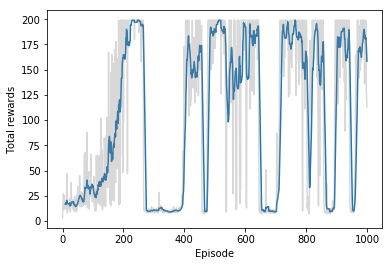

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'D losses')

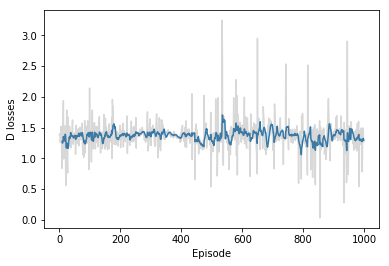

In [21]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'G losses')

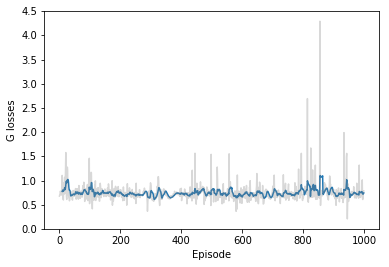

In [22]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'Q losses')

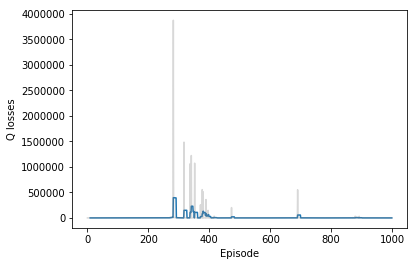

In [23]:
eps, arr = np.array(q_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Q losses')

## Testing

Let's checkout how our trained agent plays the game.

In [28]:
test_episodes = 5
test_max_steps = 2000
env.reset()
with tf.Session() as sess:
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    # Save the trained model 
    saver.restore(sess, 'checkpoints/DQAN-cartpole.ckpt')
    
    # iterations
    for ep in range(test_episodes):
        
        # number of env/rob steps
        t = 0
        while t < test_max_steps:
            env.render()
            
            # Get action from DQAN
            feed_dict = {model.states: state.reshape((1, *state.shape))}
            actions_logits = sess.run(model.actions_logits, feed_dict)
            action = np.argmax(actions_logits)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            # The task is done or not;
            if done:
                t = test_max_steps
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
            else:
                state = next_state
                t += 1

# Closing the env
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/DQAN-cartpole.ckpt


ArgumentError: argument 2: <class 'TypeError'>: wrong type

## Extending this to Deep Convolutional QAN

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.